# 3-parameter interpolation for two-qubit Cartan coordinates

In [1]:
import random
import sys,io
from scipy.spatial import Delaunay
from qctrl_optimize import hamiltonians
from qctrl_optimize import optimize as opt
from qctrl_optimize import gates
from qctrl_optimize import simulate as sim
from qctrl_optimize import interpolate as interp
from qctrl_optimize import plot as plotter
from qctrl import Qctrl
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pickle
import os
from itertools import product
qctrl = Qctrl()

In [2]:
# Set up parameters for the Interpolater

num_pwc_segments = 20
segment_count = 500
duration = np.pi
sample_times = np.linspace(0, duration, segment_count)
amplitude=1
tik0 = 1e-2
tik0 = tik0 / (amplitude**2 * num_pwc_segments)
seed = 1 # reproducability
random.seed(seed)

# get sets of reference points and testing points
def get_points(granularity):
    npts = int(1+1/granularity)
    points = np.array(list(product(np.linspace(0,1,npts), np.linspace(0,1,npts), np.linspace(0,1,npts))))
    return points
granularity_train = 1/3
granularity_test = 1/12
train_points = get_points(granularity_train)
test_points = get_points(granularity_test)

# function mapping pulse signals to Hamiltonian
def sigs_to_ham(graph, signals):
    hamiltonian, _,_,= hamiltonians.simple_hamiltonian_from_signals_1q(graph, signals)
    return hamiltonian

# function mapping (graph, target, signals) => graph.infidelity
infid_func = opt.get_ham_infid_func(sigs_to_ham)

var_shape = (2, num_pwc_segments)
# function mapping pulse optimizable variables to signal objects
vals_to_sigs = opt.get_vals_to_sigs_pwc(duration, var_shape, amplitude)

In [8]:
from_scratch = False
num_optimization_rounds = 4

result_dicts = []

In [9]:
interpolater = interp.Interpolater(qctrl, gates.r3, tik0, interp.neighbor_avg, seed, infid_func, vals_to_sigs)

opt_var_results = None
for iter in range(num_optimization_rounds):
    filename = f'interpolation_results/r3_gran4/result_dict_{iter}.pkl'
    if from_scratch or not os.path.exists(filename):
        if iter > 0:
            train_points, opt_var_results = interp.sort_points_by_tik(train_points, opt_var_results)
        opt_var_results, n_iters = interpolater.train(train_points, first_run=(iter == 0), all_opt_var_results=opt_var_results, max_iter=50)
        infids, simplices, _, _ = interpolater.test_interpolations(train_points, opt_var_results, test_points)
        result_dict = {'train_points':train_points, 'test_points':test_points, 'infids':infids, 'simplices':simplices, 'n_iters':n_iters, 'opt_var_results':opt_var_results}
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        pickle.dump(result_dict, open(filename, 'wb'))
        result_dicts.append(result_dict)
    else:
        result_dicts.append(pickle.load(open(filename, 'rb')))

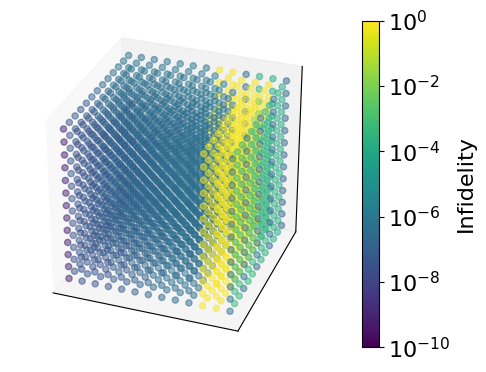

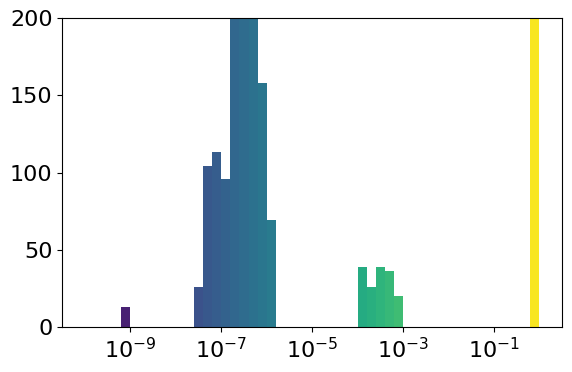

4680
1.26e-01 +- 2.81e-01, 7.68e-01


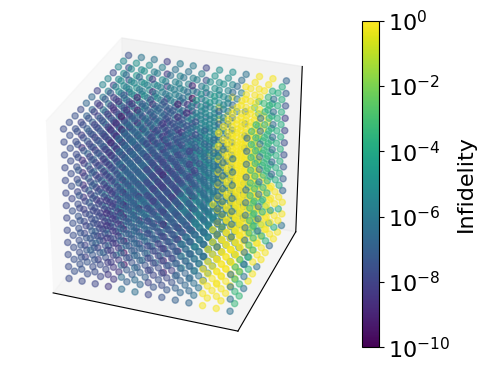

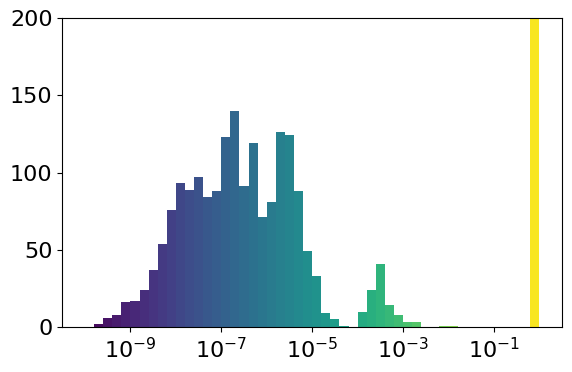

5445
1.15e-01 +- 2.70e-01, 7.75e-01


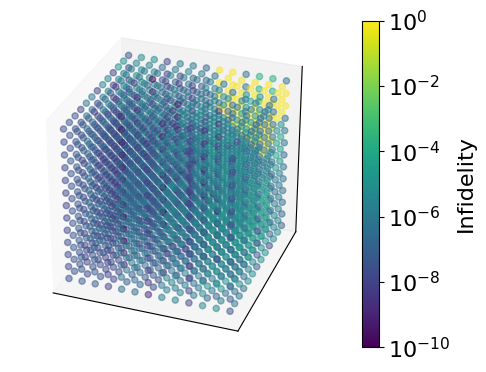

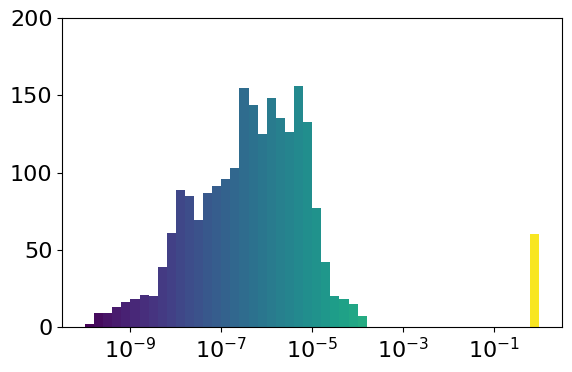

6072
2.04e-02 +- 1.22e-01, 7.67e-01


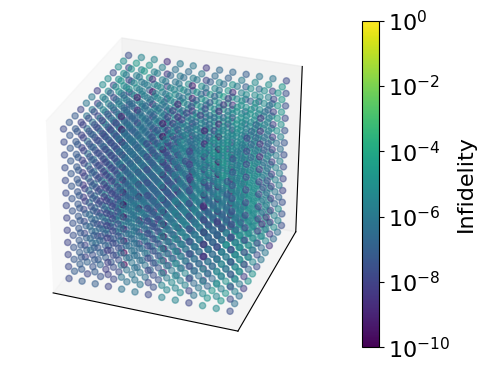

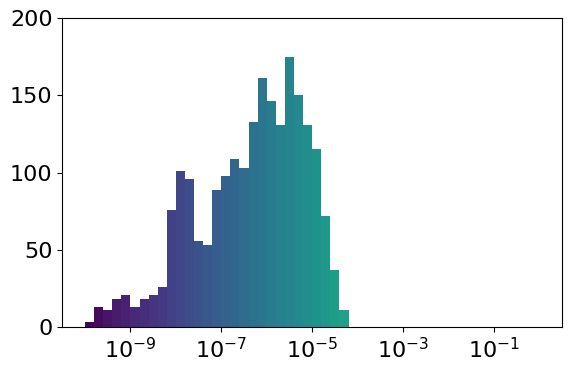

6654
3.48e-06 +- 6.63e-06, 5.36e-05


In [10]:
cum_iters = 0
plt.rcParams['font.size'] = 16
for i,result in enumerate(result_dicts):
    plotter.plot_interpolation(result['test_points'], result['infids'], result['train_points'], result['simplices'], aspect=(1,1,1), hist_ylim=(0,200), min_v=-10, draw_simplices=False, savepath=f'interpolation_results/r3_gran4/{i}_')
    cum_iters += np.sum(result['n_iters'])
    print(cum_iters)
    print(f"{np.mean(result['infids']):0.2e} +- {np.std(result['infids']):0.2e}, {np.max(result['infids']):0.2e}")